In [1]:
import torch
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v1'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cpu') # cuda:5
model_version = '2024_0813_134335'
CHECKPOINT_PATH = None
CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, _ = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='split', batch_size=1)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4
Dataset length: 49
Loaded checkpoint.


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            vis_result = viz(batch,pred)
    # if i ==5:
    
            break   
model.metrics.update(pred,batch)


tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])
tensor([[[0.2970, 0.6097]],

        [[0.2750, 0.5640]],

        [[0.2795, 0.5886]],

        [[0.2897, 0.5972]],

        [[0.2750, 0.6105]],

        [[0.2776, 0.6471]],

        [[0.2809, 0.5822]],

        [[0.3042, 0.6895]]], grad_fn=<SelectBackward0>)


In [4]:
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)

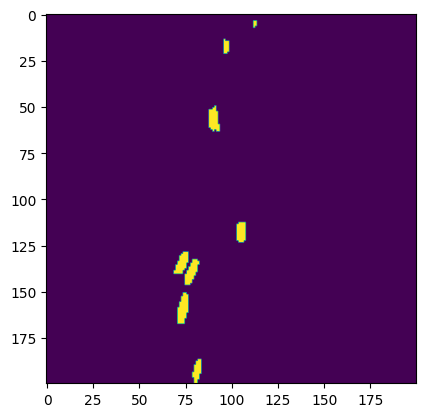

In [5]:
plt.imshow(((pred['VEHICLE'][0,0].sigmoid().detach().cpu())>0.5).numpy())

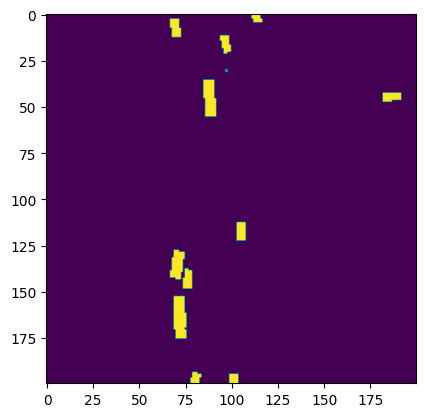

In [12]:
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
plt.imshow(vehicles[0,0].cpu().numpy())
plt.scatter([97],[30], s=3)

[[142.56   136.5728]
 [132.     126.336 ]
 [134.16   131.8464]
 [139.056  133.7728]
 [132.     136.752 ]
 [133.248  144.9504]
 [134.832  130.4128]
 [146.016  154.448 ]]


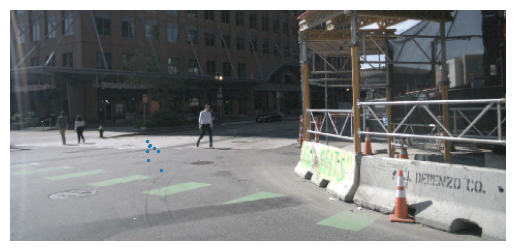

In [7]:
# mean height supervised
# x = [[[0.4953, 0.5759]],

#         [[0.5010, 0.4154]],

#         [[0.4945, 0.3754]],

#         [[0.4951, 0.5243]],

#         [[0.4952, 0.5507]],

#         [[0.4949, 0.4746]],

#         [[0.4952, 0.4506]],

#         [[0.4962, 0.6852]]]

x = [[[0.2970, 0.6097]],

        [[0.2750, 0.5640]],

        [[0.2795, 0.5886]],

        [[0.2897, 0.5972]],

        [[0.2750, 0.6105]],

        [[0.2776, 0.6471]],

        [[0.2809, 0.5822]],

        [[0.3042, 0.6895]]]

x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224
print(x)
# x = x[2:6]
plt.imshow(batch['image'][0,2].cpu().permute(1,2,0))
plt.scatter(x[:,0],x[:,1],s=2)
plt.axis('off')
plt.show()

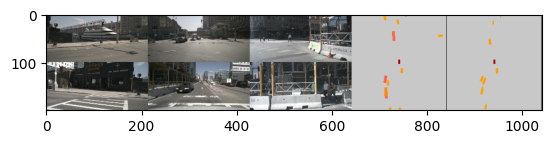

In [10]:
plt.imshow(vis_result[0])

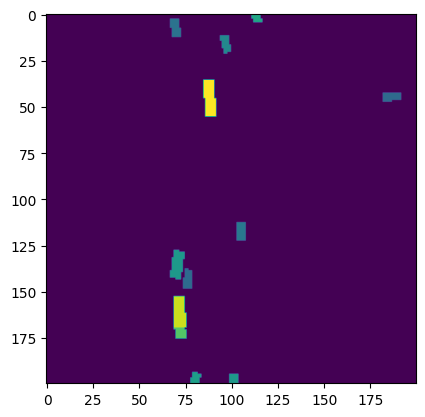

In [9]:
plt.imshow(batch['height'][0,0].cpu().numpy())